In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity('ERROR')
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from collections import defaultdict, deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from Environment_one_hot import *

In [2]:
LENGTH = 6000
WIDTH = 5000
DIVISION = 50
K = 6
NUM_BASE_STATIONS = 7

env = Environment(LENGTH, WIDTH, DIVISION, 1, 0, K)

Location and directions of cells are: 
{1: [0, 0, 0], 2: [0, 0, 1], 3: [0, 0, 2], 4: [1500.0, 0, 0], 5: [1500.0, 0, 1], 6: [1500.0, 0, 2], 7: [750.0, 1250.0, 0], 8: [750.0, 1250.0, 1], 9: [750.0, 1250.0, 2], 10: [-750.0, 1250.0, 0], 11: [-750.0, 1250.0, 1], 12: [-750.0, 1250.0, 2], 13: [-1500.0, 0, 0], 14: [-1500.0, 0, 1], 15: [-1500.0, 0, 2], 16: [-750.0, -1250.0, 0], 17: [-750.0, -1250.0, 1], 18: [-750.0, -1250.0, 2], 19: [750.0, -1250.0, 0], 20: [750.0, -1250.0, 1], 21: [750.0, -1250.0, 2]} 
 

Strongest cells for sector (0, 0)
[[13.0, -66.13575189324237], [5.0, -69.39825619992635], [20.0, -78.47993769564032], [16.0, -79.0159991699583], [10.0, -79.39007903732177], [9.0, -81.35188256835082]]


Strongest cells for sector (0, 100)
[[5.0, -68.47266999370427], [13.0, -72.12584635478302], [2.0, -77.82938129185086], [17.0, -82.16166605867052], [20.0, -84.53061862956298], [9.0, -86.10679360619605]]


Strongest cells for sector (50, 0)
[[5.0, -69.94999810184717], [13.0, -72.42896910919771], 

In [3]:
class Agent:
    def __init__(self, k, NUM_BASE_STATIONS):
        self.k = k
        cells = 3*NUM_BASE_STATIONS
        num_inputs = 3 + cells
        # Model
        #--------------------------------------------------------------------
        input_A = Input(shape = num_inputs) #(x, y, direction, current_serving_cell_one_hot_encoded)
        x = Dense(64, activation = 'relu')(input_A)
#         x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(self.k)(x)
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #--------------------------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.05)
        
        self.batch_size = 64
        self.epsilon = 0.3
        self.gamma = 0.3
        
        #Replay Buffers
        self.action_history = deque(maxlen = 10000)
        self.state_history = deque(maxlen = 10000)
        self.next_state_history = deque(maxlen = 10000)
        self.rewards_history = deque(maxlen = 10000)
        self.done_history = deque(maxlen = 10000)

        
    def play_one_step(self, state, route, dest, Wrsrp, Who):
        action = self.exp_policy(state)
        next_state, reward, done, change = env.step(state, route, action, dest)
        next_state = list(next_state)
        
        reward*=Wrsrp
        reward-=change*Who
        
        self.append_replay_buffer(state, action, next_state, reward, done)
        return next_state, reward, done, change
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(self.k)
        else:
            normalised_state = self.normalise_inputs(np.array(state)[np.newaxis])
            Q_values = self.model(normalised_state)
            return np.argmax(Q_values[0])
        
    def append_replay_buffer(self, state, action, next_state, reward, done):
        self.state_history.append(state)
        self.action_history.append(action)
        self.next_state_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)
        
    def sample_experience(self):
        indices = np.random.randint(len(self.state_history), size = self.batch_size)
        
        states = np.array([self.state_history[i] for i in indices])
        actions = np.array([self.action_history[i] for i in indices])
        next_states = np.array([self.next_state_history[i] for i in indices])
        rewards = np.array([self.rewards_history[i] for i in indices])
        dones = np.array([self.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
        
    
    def training_step(self, num_training_episode):
        for _ in range(num_training_episode):
            states, actions, next_states, rewards, dones = self.sample_experience()

            states = self.normalise_inputs(states)
            next_states = self.normalise_inputs(next_states)

            next_Q_values = self.target_model(next_states)
            max_next_Q_values = np.max(next_Q_values, axis= 1)

            target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
            mask = tf.one_hot(actions, self.k)

            with tf.GradientTape() as tape:
                all_Q_values = self.model(states)
                Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
                loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        
    def normalise_inputs(self, states):
        '''Normalising the inputs to the NN'''
        states = states.astype('float')
        states[:,0]/=(LENGTH/2)
        states[:,1]/=(WIDTH/2)
        states[:,2]/=8
        states = tf.convert_to_tensor(states)
#         print(states)
        
        return states
        
        
        

In [4]:
agent = Agent(6, NUM_BASE_STATIONS)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 3,878
Trainable params: 3,878
Non-trainable params: 0
_________________________________________________________________
None


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

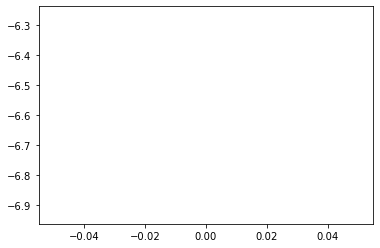

  3%|██▎                                                                           | 295/10000 [00:28<15:50, 10.21it/s]


KeyboardInterrupt: 

In [5]:
Wrsrp = 1
Who = 1
last_r = []
rewards = []
r = 100
num_training_episode = 1

for episode in tqdm(range(10000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
#     print(state)
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
    
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        last_r = []
        
    if episode>50:
        agent.training_step(num_training_episode)
    
    if episode%20==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.9
        if agent.epsilon<0.01:
            agent.epsilon = 0.01
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [ ]:
hos = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    state.append(env.sector_cells[src][0][0]) #Setting strongest cell as the initial serving cell
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    hos.append(num_hos)
    
print(np.mean(hos))